### Background

First proposed: 

Target data types in this notebook: 
- time-series

Instead of "why A?", counterfactual explanations aim to answer the question "why not B?". The intuition is that we often demand explanations for outcomes that we consider are in contrast or contradiction to what we were expecting. Then, a counterfactual explanation is one that demonstrates what needs to be changed in a model's inputs to change the decision from what was given (output A) to what was otherwise expected (output B). The following steps are taken by typical counterfactual implementations:

- 

### Drawbacks
Rashomon effect (What is that?)

Import Packages

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import os
import numpy as np
import pandas as pd
from omnixai.data.timeseries import Timeseries
from omnixai.explainers.timeseries import MACEExplainer

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# Load the time series dataset
df = pd.read_csv(os.path.join("./data", "timeseries.csv"))
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')
df = df.rename(columns={"horizontal": "values"})
df = df.set_index("timestamp")
df = df.drop(columns=["anomaly"])
print(df)

                       values
timestamp                    
1970-01-01 00:00:00  1.928031
1970-01-01 00:05:00 -1.156620
1970-01-01 00:10:00 -0.390650
1970-01-01 00:15:00  0.400804
1970-01-01 00:20:00 -0.874490
...                       ...
1970-02-04 16:55:00  0.362724
1970-02-04 17:00:00  2.657373
1970-02-04 17:05:00  1.472341
1970-02-04 17:10:00  1.033154
1970-02-04 17:15:00  2.950466

[10000 rows x 1 columns]


In [4]:
# Split the dataset into training and test splits
train_df = df.iloc[:9150]
test_df = df.iloc[9150:9300]
# A simple threshold for detecting anomaly data points
threshold = np.percentile(train_df["values"].values, 90)

In [5]:
# A simple detector for determining whether a window of time series is anomalous
def detector(ts: Timeseries):
    anomaly_scores = np.sum((ts.values > threshold).astype(int))
    return anomaly_scores / ts.shape[0]

In [14]:
explainer = MACEExplainer(
    training_data=Timeseries.from_pd(train_df),
    predict_function=detector,
    mode="anomaly_detection",
    threshold=0.001
)
test_x = Timeseries.from_pd(test_df)


In [15]:
explanations = explainer.explain(test_x)


 |███████████████████████████████████████-| 98.0% 

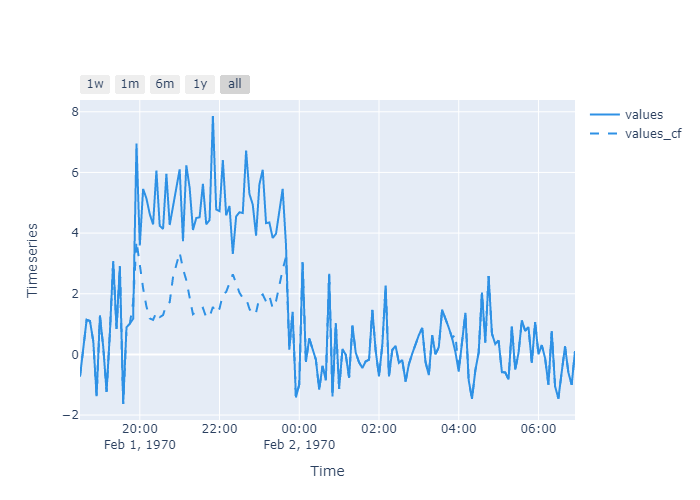

In [16]:
explanations.ipython_plot()

In [13]:
explanations.get_explanations()

[{'query':                        values
  1970-02-01 18:30:00 -0.724390
  1970-02-01 18:35:00  0.119763
  1970-02-01 18:40:00  1.142472
  1970-02-01 18:45:00  1.103280
  1970-02-01 18:50:00  0.429136
  ...                       ...
  1970-02-02 06:35:00 -0.581458
  1970-02-02 06:40:00  0.265073
  1970-02-02 06:45:00 -0.595560
  1970-02-02 06:50:00 -1.001043
  1970-02-02 06:55:00  0.113221
  
  [150 rows x 1 columns],
  'counterfactual':                        values
  1970-02-01 18:30:00 -0.726040
  1970-02-01 18:35:00  0.117965
  1970-02-01 18:40:00  1.140731
  1970-02-01 18:45:00  1.101591
  1970-02-01 18:50:00  0.427179
  ...                       ...
  1970-02-02 06:35:00 -0.583232
  1970-02-02 06:40:00  0.263297
  1970-02-02 06:45:00 -0.597286
  1970-02-02 06:50:00 -1.002809
  1970-02-02 06:55:00  0.111572
  
  [150 rows x 1 columns]}]

In [28]:
test_instances

                       values
1970-02-02 06:35:00 -0.581458
1970-02-02 06:40:00  0.265073
1970-02-02 06:45:00 -0.595560
1970-02-02 06:50:00 -1.001043
1970-02-02 06:55:00  0.113221

In [30]:
test_instances = test_x
local_explanations = explainer.explain(X=test_instances)

 |███████████████████████████████████████-| 98.0% 

In [35]:
from omnixai.explainers.timeseries import TimeseriesExplainer
from omnixai.visualization.dashboard import Dashboard

In [34]:
# Initialize a TimeseriesExplainer
explainers = TimeseriesExplainer(
    explainers=["shap", "mace"],        # Apply SHAP and MACE explainers
    mode="anomaly_detection",           # An anomaly detection task
    data=Timeseries.from_pd(train_df),  # Set data for initializing the explainers
    model=detector,                     # Set the black-box anomaly detector
    preprocess=None,
    postprocess=None,
    params={"mace": {"threshold": 0.001}}   # Additional parameters for MACE
)
# Generate local explanations
test_instance = Timeseries.from_pd(test_df)
local_explanations = explainers.explain(test_instance)
# Launch a dashboard for visualization
dashboard = Dashboard(instances=test_instance, local_explanations=local_explanations)
dashboard.show()

100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


 |███████████████████████████████████████-| 98.0% 

In [9]:
import os
import sklearn
import xgboost
import numpy as np
import pandas as pd
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import MACEExplainer

In [10]:
feature_names = [
    "Age", "Workclass", "fnlwgt", "Education",
    "Education-Num", "Marital Status", "Occupation",
    "Relationship", "Race", "Sex", "Capital Gain",
    "Capital Loss", "Hours per week", "Country", "label"
]
data = np.genfromtxt(os.path.join('./data', 'adult.data'), delimiter=', ', dtype=str)
tabular_data = Tabular(
    data,
    feature_columns=feature_names,
    categorical_columns=[feature_names[i] for i in [1, 3, 5, 6, 7, 8, 9, 13]],
    target_column='label'
)
print(tabular_data)

      Age         Workclass  fnlwgt   Education Education-Num  \
0      39         State-gov   77516   Bachelors            13   
1      50  Self-emp-not-inc   83311   Bachelors            13   
2      38           Private  215646     HS-grad             9   
3      53           Private  234721        11th             7   
4      28           Private  338409   Bachelors            13   
...    ..               ...     ...         ...           ...   
32556  27           Private  257302  Assoc-acdm            12   
32557  40           Private  154374     HS-grad             9   
32558  58           Private  151910     HS-grad             9   
32559  22           Private  201490     HS-grad             9   
32560  52      Self-emp-inc  287927     HS-grad             9   

           Marital Status         Occupation   Relationship   Race     Sex  \
0           Never-married       Adm-clerical  Not-in-family  White    Male   
1      Married-civ-spouse    Exec-managerial        Husband  Wh

In [11]:
np.random.seed(1)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)
train, test, labels_train, labels_test = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(train, labels_train)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(labels_test, gbtree.predict(test))))
predict_function=lambda z: gbtree.predict_proba(transformer.transform(z))


Training data shape: (26048, 108)
Test data shape:     (6513, 108)
Test accuracy: 0.8661139259941655


In [12]:
explainer = MACEExplainer(
    training_data=tabular_data,
    predict_function=predict_function,
    ignored_features=["Sex", "Race", "Relationship", "Capital Loss"]
)
test_instances = tabular_data.remove_target_column()[0:5]

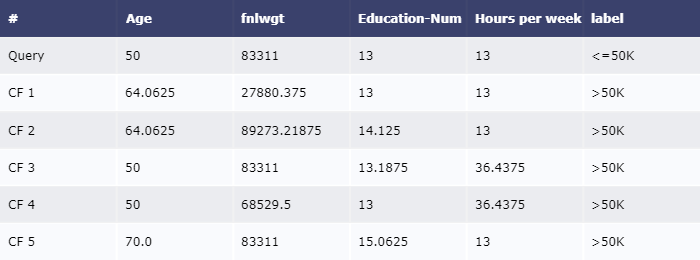

In [13]:
explanations = explainer.explain(test_instances)
explanations.ipython_plot(index=1, class_names=class_names)

### Try with another dataset